# Exercise 2: My first compatibility study

## License

```
Basic conversion formulas for Radioastronomy.
Copyright (C) 2012+  Axel Jessner (jessner@mpifr.de)
              2015+  Benjamin Winkel (bwinkel@mpifr.de)

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
```

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from pycraf import conversions as cnv

## Exercises

### Kepler's anniversary

Johannes Kepler was born on December 27, 1571. To celebrate his 450th anniversary, the government of the state of North-Rhine-Westphalia decides to switch off all artificial light sources on December 27, 2021, so that people can finally enjoy the stars in the sky in the middle of Europe.

Unfortunately, hundreds of amateur astronomers make themselves ready to use their sophisticated and highly automated optical telescopes during this night. It is well known, that especially the Pro-OBS-2000 telescope motorized mount has insufficient shielding and produces radio frequency interference at multiples of an oscillator running at 48.5 MHz. On of the harmonics happens to lie at 1406.5 MHz, close to the important 21-cm HI line at 1420 MHz and well within the protected RAS band.

Therefore, the German administration has asked you, to provide the necessary calculations to determine a protection zone around the 100-m radio telescope at Effelsberg, such that no harm is put to radio observations on that night.

### Emission characteristics

Since HI line observations are planned, we have to use the spectral-line limits of ITU-R RA.769.

- What is the permitted power limit that applies and what is the bandwidth of a spectral channel?

In [3]:
from pycraf import protection

In [4]:
ra769_limits = protection.ra769_limits(mode='spectroscopy')
ra769_limits

frequency,bandwidth,T_A,T_rx,T_rms,P_rms_nu,Plim,Plim_nu,Slim,Slim_nu,Efield,Efield_norm
MHz,kHz,K,K,mK,dB(W / Hz),dB(W),dB(W / Hz),dB(W / m2),dB(W / (Hz m2)),dB(uV2 / m2),dB(uV2 / m2)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
327,10,40,60,22.361,-245.1,-215.1,-255.1,-203.4,-243.4,-57.6,-37.6
1420,20,12,10,3.479,-253.2,-220.2,-263.2,-195.7,-238.7,-49.9,-32.9
1612,20,12,10,3.479,-253.2,-220.2,-263.2,-194.6,-237.6,-48.8,-31.8
1665,20,12,10,3.479,-253.2,-220.2,-263.2,-194.3,-237.3,-48.5,-31.5
4830,50,12,10,2.200,-255.2,-218.2,-265.2,-183.1,-230.0,-37.3,-24.3
14488,150,15,15,1.732,-256.2,-214.5,-266.2,-169.8,-221.5,-24.0,-15.8
22200,250,35,30,2.907,-254.0,-210.0,-264.0,-161.6,-215.6,-15.8,-9.8
23700,250,35,30,2.907,-254.0,-210.0,-264.0,-161.0,-215.0,-15.3,-9.3


In [5]:
ra769_limits[1]

frequency,bandwidth,T_A,T_rx,T_rms,P_rms_nu,Plim,Plim_nu,Slim,Slim_nu,Efield,Efield_norm
MHz,kHz,K,K,mK,dB(W / Hz),dB(W),dB(W / Hz),dB(W / m2),dB(W / (Hz m2)),dB(uV2 / m2),dB(uV2 / m2)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1420,20,12,10,3.479,-253.2,-220.2,-263.2,-195.7,-238.7,-49.9,-32.9


In [6]:
bandwidth_ras = ra769_limits['bandwidth'][1] * ra769_limits['bandwidth'].unit
Plim_ras = ra769_limits['Plim'][1] * ra769_limits['Plim'].unit

In [7]:
bandwidth_ras, Plim_ras

(<Quantity 20.0 kHz>, <Decibel -220.1749418748753 dB(W)>)

The strength of the RFI line is -70 dBm/Hz and it has a width of 2.5 Hz.

- How much power goes into the spectral channel (defined in RA.769)?

In [8]:
P_rfi_nu = ((-70 * cnv.dBm).to(u.W) / u.Hz)
bandwidth_rfi = 2.5 * u.Hz

In [9]:
P_rfi = (P_rfi_nu * bandwidth_rfi).to(u.W)
P_rfi.to(u.nW), P_rfi.to(cnv.dB_W)

(<Quantity 0.24999999999999997 nW>, <Decibel -96.02059991327963 dB(W)>)

### Separation distances

-  What is the minimal coupling loss, i.e., the necessary amount of attenuation to bring the RFI signal below the RA.769 levels?

In [10]:
MCL = (P_rfi.to_value(cnv.dB_W) - Plim_ras.to_value(cnv.dB_W)) * cnv.dB
MCL

<Decibel 124.15434196159566 dB>

- Assuming Line-of-Sight attenuation only, what is the minimal distance that a single interferer must have from the telescope?

In [11]:
freq = 1.4065 * u.GHz

In [12]:
cnv.free_space_loss(27 * u.km, freq)  # play with the number, until it fits the MCL

<Decibel -124.03785323508751 dB>

In [13]:
# better: use optimization
from scipy.optimize import minimize

def objective_function(dist):
    loss = cnv.free_space_loss(dist * u.km, freq)
    return abs(MCL.to_value(cnv.dB) + loss.to_value(cnv.dB))

# objective_function(20)

fit_result = minimize(objective_function, 20)
print(fit_result)
min_dist = float(fit_result['x']) * u.km
print(min_dist, cnv.free_space_loss(min_dist, freq))

      fun: 2.0584707272064406e-09
 hess_inv: array([[ 6.82727677]])
      jac: array([ 0.04113007])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 267
      nit: 2
     njev: 85
   status: 2
  success: False
        x: array([ 27.36454305])
27.36454304743165 km -124.15434195953719 dB


Fortunately, Effelsberg is surrounded by some hills, which provide additional shielding.

- Calculate the exclusion zone around the 100-m based on the topography and visualize it!

In [14]:
from pycraf import pathprof

In [15]:
omega = 0. * u.percent  # fraction of path over sea
temperature = 275. * u.K
pressure = 1013. * u.hPa
timepercent = 2 * u.percent  # see P.452 for explanation
h_rt, h_mount = 50 * u.m, 1 * u.m
G_t, G_r = 0 * cnv.dBi, 0 * cnv.dBi
zone_t, zone_r = pathprof.CLUTTER.UNKNOWN, pathprof.CLUTTER.UNKNOWN
hprof_step = 100 * u.m


In [16]:
lon_rt, lat_rt = 6.88361 * u.deg, 50.52483 * u.deg
map_size_lon, map_size_lat = 0.3 * u.deg, 0.3 * u.deg
map_resolution = 3. * u.arcsec

In [17]:
hprof_cache = pathprof.height_map_data(
    lon_rt, lat_rt,
    map_size_lon, map_size_lat,
    map_resolution=map_resolution,
    zone_t=zone_t, zone_r=zone_r,
    )

In [18]:
results = pathprof.atten_map_fast(
    freq,
    temperature,
    pressure,
    h_rt, h_mount,
    timepercent,
    hprof_cache,  # dict_like
    )

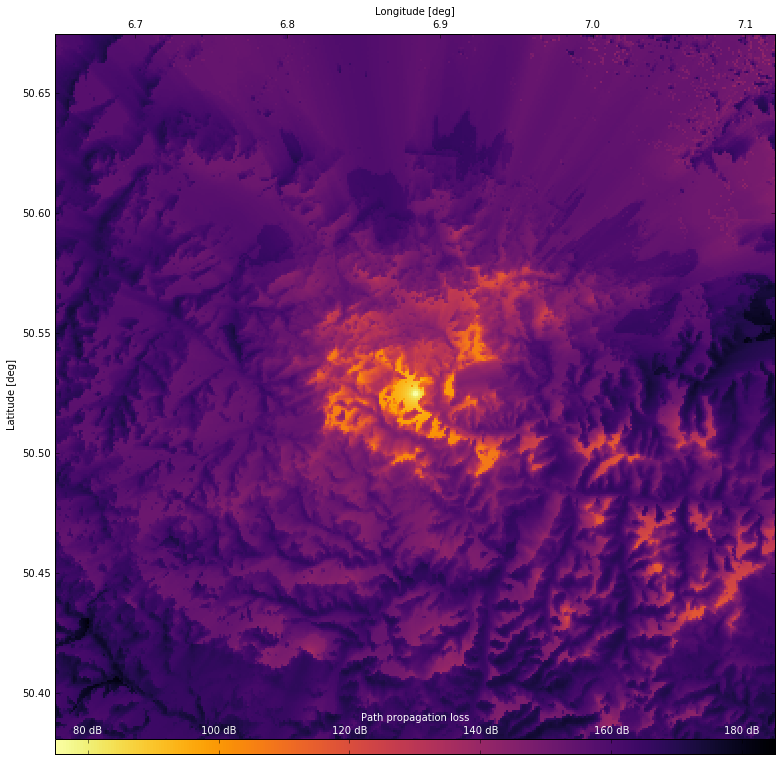

In [19]:
_lons = hprof_cache['xcoords']
_lats = hprof_cache['ycoords']
bbox = (_lons[0], _lons[-1], _lats[0], _lats[-1])
_total_atten = results['L_b']  # see description of atten_map_fast

vmin, vmax = 75, 185

plt.close()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
cim = ax.imshow(
    _total_atten,
    origin='lower', interpolation='nearest', cmap='inferno_r',
    vmin=vmin, vmax=vmax,
    extent=bbox,
    )
cbar = fig.colorbar(
    cim, cax=cbax, orientation='horizontal'
    )
ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))
cbar.set_label(r'Path propagation loss', color='w')
cbax.xaxis.set_label_position('top')
for t in cbax.xaxis.get_major_ticks():
    t.tick1On = True
    t.tick2On = True
    t.label1On = False
    t.label2On = True
ctics = np.arange(80, 200, 20)
cbar.set_ticks(ctics)
cbar.ax.set_xticklabels(map('{:.0f} dB'.format, ctics), color='w')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.show()

In [20]:
_lons2d, _lats2d = np.meshgrid(_lons, _lats)
heightmap = pathprof.srtm_height_data(_lons2d * u.deg, _lats2d * u.deg)

In [21]:
bearings = np.linspace(-180, 180, 721)[:, np.newaxis] * u.deg
circle_radii = np.arange(5, 21, 5)[np.newaxis] * u.km

circle_lons, circle_lats, _ = pathprof.geoid_direct(
    lon_rt, lat_rt, bearings, circle_radii
    )


In [22]:
_heightmap = heightmap.to_value(u.m)
vmax = 840
terrain_cmap, terrain_norm = pathprof.terrain_cmap_factory(sealevel=0.5, vmax=vmax)
_heightmap[_heightmap < 0] = 0.51  # fix for coastal region


In [23]:
margin = MCL.to_value(cnv.dB) - _total_atten.to_value(cnv.dB)

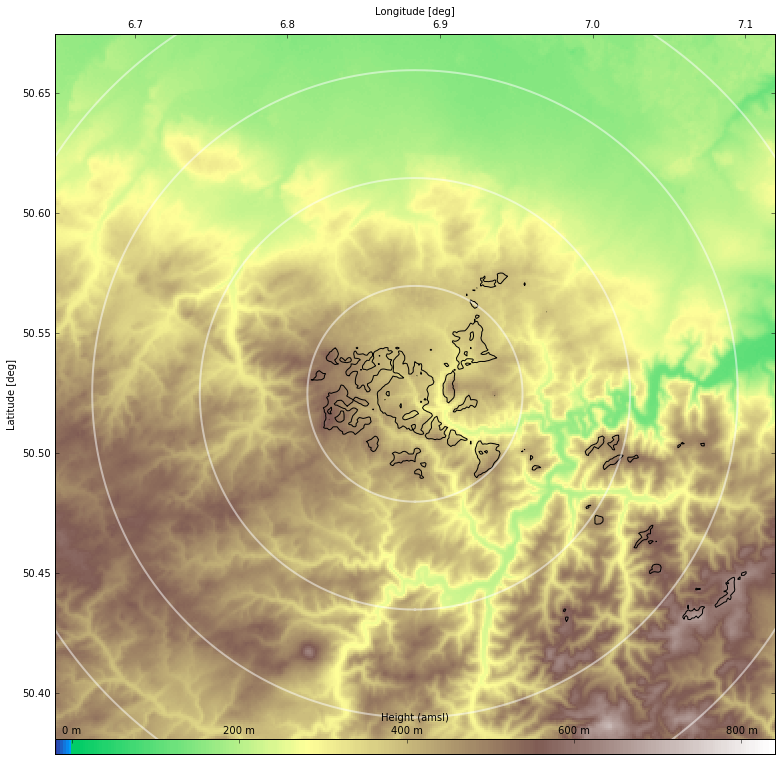

In [24]:
plt.close()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
cim = ax.imshow(
    _heightmap,
    origin='lower', interpolation='nearest',
    cmap=terrain_cmap, norm=terrain_norm,
    vmin=-20, vmax=vmax,
    extent=bbox,
    )

ax.plot(
    circle_lons.to_value(u.deg), circle_lats.to_value(u.deg), 'w-',
    lw=2, alpha=0.5
    )
ax.set_xlim(bbox[:2])
ax.set_ylim(bbox[2:])

colors = ['k']
levels = [0]
cs = ax.contour(
    -margin, levels,
    linewidths=1, colors=colors, origin='lower',
    extent=bbox,
    )
cbar = fig.colorbar(
    cim, cax=cbax, orientation='horizontal'
    )

plt.setp(cs.collections, rasterized=True)
ax.set_aspect((bbox[1] - bbox[0]) / (bbox[3] - bbox[2]))
cbar.set_label(r'Height (amsl)', color='k')
cbax.xaxis.set_label_position('top')
for t in cbax.xaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = True
    t.label1On = False
    t.label2On = True
ctics = np.arange(0, 2000, 200)
cbar.set_ticks(ctics)
cbar.ax.set_xticklabels(map('{:.0f} m'.format, ctics), color='k')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.show()

### Simple aggregation

A group of amateur astronomers builds a camp well outside of the exclusion zone at $(l, b)=(6.9^\circ, 50.57^\circ)$.

- How many Pro-OBS-2000 mounts are at most tolerable before the aggregated emission will again be above the RA.769 levels?

In [25]:
# calculate attenuation between RT and camp
lon_camp, lat_camp = 6.9 * u.deg, 50.57 * u.deg

In [26]:
# this time, we can safely assume that a camp will be located in some open field
zone_t = pathprof.CLUTTER.SPARSE

In [27]:
pprop = pathprof.PathProp(
    freq,
    temperature, pressure,
    lon_camp, lat_camp,
    lon_rt, lat_rt,
    h_mount, h_rt,
    hprof_step,
    timepercent,
    zone_t=zone_t, zone_r=zone_r,
    )

In [28]:
tot_loss = pathprof.loss_complete(pprop, G_t, G_r)
(L_bfsg, L_bd, L_bs, L_ba, L_b, L_b_corr, L) = tot_loss
print('L_bfsg:   {0.value:5.2f} {0.unit} - Free-space loss'.format(L_bfsg))
print('L_bd:     {0.value:5.2f} {0.unit} - Basic transmission loss associated with diffraction'.format(L_bd))
print('L_bs:     {0.value:5.2f} {0.unit} - Tropospheric scatter loss'.format(L_bs))
print('L_ba:     {0.value:5.2f} {0.unit} - Ducting/layer reflection loss'.format(L_ba))
print('L_b:      {0.value:5.2f} {0.unit} - Complete path propagation loss'.format(L_b))
print('L_b_corr: {0.value:5.2f} {0.unit} - As L_b but with clutter correction'.format(L_b_corr))
print('L:        {0.value:5.2f} {0.unit} - As L_b_corr but with gain correction'.format(L))

L_bfsg:   109.75 dB - Free-space loss
L_bd:     143.05 dB - Basic transmission loss associated with diffraction
L_bs:     165.05 dB - Tropospheric scatter loss
L_ba:     137.77 dB - Ducting/layer reflection loss
L_b:      142.54 dB - Complete path propagation loss
L_b_corr: 160.55 dB - As L_b but with clutter correction
L:        160.55 dB - As L_b_corr but with gain correction


In [29]:
P_allowed = (Plim_ras.to_value(cnv.dB_W) + L.to_value(cnv.dB)) * cnv.dB_W
P_allowed

<Decibel -59.62047269986354 dB(W)>

In [30]:
P_allowed.to_value(u.W) / P_rfi.to_value(u.W)

4365.286188367763

This number is large enough, such that problems are not to be expected.

### Deadlines...

Everything goes as planned. However, one day before the event, you get a phone call: a Chinese vendor sold hundreds of LED based flash lights to the amateur astronomers, which leak broadband emission into the L-band. The estimated power level is -50 dBm/MHz over the full protected RAS band. You have 30 minutes to calculate the necessary single-interferer exclusion zone, before it is too late!

- Repeat the separation-distance calculations (as above) for the LED spectrum (RA.769 continuum case).

In [31]:
ra769_limits = protection.ra769_limits(mode='continuum')
ra769_limits

frequency,bandwidth,T_A,T_rx,T_rms,P_rms_nu,Plim,Plim_nu,Slim,Slim_nu,Efield,Efield_norm
MHz,MHz,K,K,mK,dB(W / Hz),dB(W),dB(W / Hz),dB(W / m2),dB(W / (Hz m2)),dB(uV2 / m2),dB(uV2 / m2)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
13,0,50000,60,5006.000,-221.6,-184.6,-231.6,-200.6,-247.6,-54.9,-41.9
26,0,15000,60,972.119,-228.7,-187.9,-238.7,-198.3,-249.1,-52.5,-43.3
74,2,750,60,14.319,-247.0,-195.0,-257.0,-196.2,-258.2,-50.4,-52.5
152,3,150,60,2.734,-254.2,-199.5,-264.2,-194.5,-259.2,-48.7,-53.4
325,7,40,60,0.870,-259.2,-201.0,-269.2,-189.3,-257.5,-43.5,-51.7
408,4,25,60,0.962,-258.8,-202.9,-268.8,-189.2,-255.1,-43.4,-49.3
611,6,20,60,0.730,-260.0,-202.2,-270.0,-185.0,-252.8,-39.2,-47.0
1414,27,12,10,0.095,-268.8,-204.5,-278.8,-180.1,-254.4,-34.3,-48.6


In [32]:
ra769_limits[7]

frequency,bandwidth,T_A,T_rx,T_rms,P_rms_nu,Plim,Plim_nu,Slim,Slim_nu,Efield,Efield_norm
MHz,MHz,K,K,mK,dB(W / Hz),dB(W),dB(W / Hz),dB(W / m2),dB(W / (Hz m2)),dB(uV2 / m2),dB(uV2 / m2)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1414,27,12,10,0.095,-268.8,-204.5,-278.8,-180.1,-254.4,-34.3,-48.6


In [33]:
bandwidth_ras = ra769_limits['bandwidth'][7] * ra769_limits['bandwidth'].unit
Plim_ras = ra769_limits['Plim'][7] * ra769_limits['Plim'].unit

In [34]:
P_rfi_nu = -50 * cnv.dBm_MHz
bandwidth_rfi = bandwidth_ras

In [35]:
P_rfi = (P_rfi_nu.to(u.W / u.Hz) * bandwidth_rfi).to(u.W)
P_rfi.to(u.nW), P_rfi.to(cnv.dB_W)

(<Quantity 270.00000000000006 nW>, <Decibel -65.68636235841012 dB(W)>)

In [36]:
MCL = (P_rfi.to_value(cnv.dB_W) - Plim_ras.to_value(cnv.dB_W)) * cnv.dB
MCL

<Decibel 138.83691067399013 dB>

In [37]:
margin = MCL.to_value(cnv.dB) - _total_atten.to_value(cnv.dB)

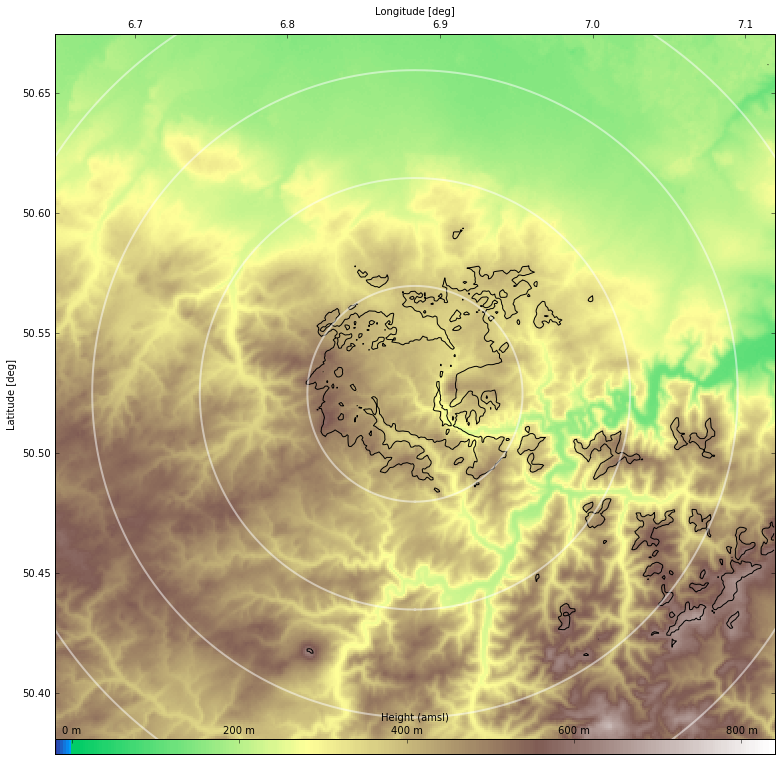

In [38]:
plt.close()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
cim = ax.imshow(
    _heightmap,
    origin='lower', interpolation='nearest',
    cmap=terrain_cmap, norm=terrain_norm,
    vmin=-20, vmax=vmax,
    extent=bbox,
    )

ax.plot(
    circle_lons.to_value(u.deg), circle_lats.to_value(u.deg), 'w-',
    lw=2, alpha=0.5
    )
ax.set_xlim(bbox[:2])
ax.set_ylim(bbox[2:])

colors = ['k']
levels = [0]
cs = ax.contour(
    -margin, levels,
    linewidths=1, colors=colors, origin='lower',
    extent=bbox,
    )
cbar = fig.colorbar(
    cim, cax=cbax, orientation='horizontal'
    )

plt.setp(cs.collections, rasterized=True)
ax.set_aspect((bbox[1] - bbox[0]) / (bbox[3] - bbox[2]))
cbar.set_label(r'Height (amsl)', color='k')
cbax.xaxis.set_label_position('top')
for t in cbax.xaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = True
    t.label1On = False
    t.label2On = True
ctics = np.arange(0, 2000, 200)
cbar.set_ticks(ctics)
cbar.ax.set_xticklabels(map('{:.0f} m'.format, ctics), color='k')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.show()